An important part of the everyday tasks of a data scientist is data wrangling. Input data must be accessed, retrieved, understood, and transformed before machine learning can be applied to create predictive models. While most talk is around deep learning these days, this less sexy topic is arguably more important for real life situations. 

A common example of data wrangling is dealing with time series data and resample this data to custom time periods. The python library Pandas is well suited to this task, but what if the data volume is in the range of terabytes or larger? This blog post introduces Spark dataframes and shows how to perform the same data manipulation on Spark dataframes and Pandas dataframes.

# Table of Contents
* [Input data](#Input-data)
	* [Reshaping the data](#Reshaping-the-data)
	* [Resampling time series with Pandas](#Resampling-time-series-with-Pandas)
* [Working with time series data with Spark](#Working-with-time-series-data-with-Spark)
	* [Resampling time series with Spark](#Resampling-time-series-with-Spark)
* [Visualize results](#Visualize-results)
* [Summary](#Summary)


In [1]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as dates
from IPython.display import display

import customcolors # private class for colors

%matplotlib inline

# Input data

The data we will use for this exercise is [publicly available data](https://www.swissgrid.ch/swissgrid/en/home/experts/topics/energy_data_ch.html) from Swissgrid, the national energy grid company in Switzerland. As the owner of Switzerland's extra-high-voltage grid, it is responsible for the safe operation of the grid without discrimination, and for maintaining, modernizing and expanding the grid efficiently and with respect for the environment.

First we import the data into a Pandas dataframe and take a look at what data we were given:

In [2]:
url = 'https://www.swissgrid.ch/dam/dataimport/energy_data/en/EnergieUebersichtCH_2017.xls'
df = pd.read_excel(url, sheetname='Zeitreihen0h15')
df.drop(['Zeitstempel'], inplace=True)
df = df.apply(pd.to_numeric, errors='coerce', axis=1)
print (df.info())
display (df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 23324 entries, 2017-01-01 00:15:00 to 2017-09-01 00:00:00
Data columns (total 64 columns):
Summe endverbrauchte Energie Regelblock Schweiz
Total energy consumed by end users in the Swiss controlblock    23324 non-null float64
Summe produzierte Energie Regelblock Schweiz
Total energy production Swiss controlblock                         23324 non-null float64
Summe verbrauchte Energie Regelblock Schweiz
Total energy consumption Swiss controlblock                        23324 non-null float64
Netto Ausspeisung aus dem Übertragungsnetz Schweiz
Net outflow of the Swiss transmission grid                   23324 non-null float64
Vertikale Einspeisung ins Übertragungsnetz Schweiz
Grid feed-in Swiss transmission grid                         23324 non-null float64
Positive Sekundär-Regelenergie
Positive secundary control energy                                                23324 non-null float64
Negative Sekundär-Regelenergie
Negative secundary cont

,Summe endverbrauchte Energie Regelblock Schweiz Total energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz Total energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz Total energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz Net outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz Grid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie Positive secundary control energy,Negative Sekundär-Regelenergie Negative secundary control energy,Positive Tertiär-Regelenergie Positive tertiary control energy,Negative Tertiär-Regelenergie Negative tertiary control energy,Verbundaustausch CH->AT Cross Border Exchange CH->AT,...,"Produktion Kantone OW, NW, UR Production Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR Consumption Cantons OW, NW, UR","Produktion Kantone GE, VD Production Cantons GE, VD","Verbrauch Kantone GE, VD Consumption Cantons GE, VD","Produktion Kantone SH, ZH Production Cantons SH, ZH","Verbrauch Kantone SH, ZH Consumption Cantons SH, ZH",Produktion Kantonsübergreifend Production across Cantons,Verbrauch Kantonsübergreifend Consumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete Production control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete Consumption control area CH - foreign territories
count,2.332400e+04,2.332400e+04,2.332400e+04,2.332400e+04,2.332400e+04,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000,...,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000,23324.000000
mean,1.593932e+06,1.731990e+06,1.807009e+06,2.328525e+05,1.243521e+06,4340.074601,-4570.258103,3203.127680,-4354.991983,13532.953181,...,31595.476325,24086.363769,76161.389659,228050.767124,26484.497775,262090.034227,75532.894004,59104.245627,2881.729592,19771.154039
std,3.205078e+05,4.885720e+05,2.685633e+05,3.249454e+05,4.039557e+05,9318.500634,9373.320045,9456.763301,11059.461742,24813.468604,...,17318.778944,5751.354705,39199.796830,42925.652090,5714.876105,53414.182328,23074.226824,17434.538497,1689.043993,4361.777840
min,9.208942e+05,7.947005e+05,1.117634e+06,0.000000e+00,5.234552e+05,0.000000,-95200.000000,0.000000,-88750.000000,0.000000,...,1821.586000,11759.485000,16973.997000,120725.659000,16610.533000,151934.272000,27396.250000,13131.067000,362.789000,10325.925000
25%,1.330649e+06,1.400675e+06,1.597206e+06,0.000000e+00,9.537414e+05,0.000000,-4600.000000,0.000000,0.000000,0.000000,...,17264.621000,19784.920000,48503.758500,198581.431750,22958.668250,220183.979250,59116.868750,45980.104750,1211.170500,16259.536750
50%,1.590471e+06,1.638829e+06,1.780831e+06,5.221323e+04,1.146028e+06,0.000000,-100.000000,0.000000,0.000000,0.000000,...,30115.917500,23675.985000,66057.567500,231048.649000,24958.539500,261886.465500,76950.669500,59903.073500,3138.029000,19444.365500
75%,1.798049e+06,2.051011e+06,1.979740e+06,3.658321e+05,1.489164e+06,3900.000000,0.000000,0.000000,0.000000,19400.000000,...,45254.911750,27751.476250,94573.219500,255558.276250,29096.784250,298229.504250,91585.888250,72603.994500,4064.887500,23520.843750
max,2.501306e+06,3.357186e+06,2.641469e+06,1.309385e+06,2.704454e+06,98800.000000,0.000000,113750.000000,0.000000,273000.000000,...,78966.473000,40305.983000,186498.118000,376404.831000,45514.345000,412174.731000,141673.600000,113814.444000,8082.150000,31638.518000


,Summe endverbrauchte Energie Regelblock Schweiz Total energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz Total energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz Total energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz Net outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz Grid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie Positive secundary control energy,Negative Sekundär-Regelenergie Negative secundary control energy,Positive Tertiär-Regelenergie Positive tertiary control energy,Negative Tertiär-Regelenergie Negative tertiary control energy,Verbundaustausch CH->AT Cross Border Exchange CH->AT,...,"Produktion Kantone OW, NW, UR Production Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR Consumption Cantons OW, NW, UR","Produktion Kantone GE, VD Production Cantons GE, VD","Verbrauch Kantone GE, VD Consumption Cantons GE, VD","Produktion Kantone SH, ZH Production Cantons SH, ZH","Verbrauch Kantone SH, ZH Consumption Cantons SH, ZH",Produktion Kantonsübergreifend Production across Cantons,Verbrauch Kantonsübergreifend Consumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete Production control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete Consumption control area CH - foreign territories
2017-01-01 00:15:00,1659089.647,1070125.185,1769658.748,663532.117746,782636.342,79900.0,0.0,0.0,0.0,0.0,...,17689.802,34281.702,21127.373,193703.757,20974.202,267591.729,33346.900,43895.391,624.820,13648.421
2017-01-01 00:30:00,1649854.573,1062728.852,1755999.820,657153.279653,772462.414,72400.0,0.0,0.0,0.0,0.0,...,15938.283,33941.883,21181.238,189903.775,21062.978,264398.659,32390.725,43147.298,577.188,13795.876
2017-01-01 00:45:00,1677086.704,1097756.391,1787020.023,651561.715656,811001.242,75200.0,0.0,25000.0,0.0,0.0,...,18603.804,33957.305,21011.788,187117.423,20978.036,285073.981,32023.450,43096.412,582.305,13364.648
2017-01-01 01:00:00,1662763.999,1052546.612,1791103.482,702079.121571,772132.155,25300.0,0.0,25000.0,0.0,0.0,...,15264.713,33172.214,21014.531,191260.350,20868.608,282076.254,32019.700,42379.035,573.289,13206.982
2017-01-01 01:15:00,1673310.190,1067108.197,1881700.693,776303.600163,803179.657,96900.0,0.0,25000.0,0.0,0.0,...,24918.682,34987.982,22518.970,242031.240,20824.065,281033.207,33422.050,40557.406,577.445,13091.809


The above command can take a while to complete since we are reading in a rather large Excel file directly from Swissgrid's website. The resulting Pandas dataframe contains 64 columns with long header names, sometimes including line breaks. We also note that some columns represent data from a specific Swiss canton, while other columns contains data of two or more cantons summed up. All data is numerical with no null values, so there is no immediate data quality concern. The rows represent snapshots with 15 minute intervals.

## Reshaping the data

As we saw above, the input data is already quite tidy. Features are represented by individual columns and every row is a set of measurements. This a good schema for machine learning or data analysis. However, when working with raw data from e.g., IoT devices or log files, things are not served on a silver plate. Let's make the data more "realistic" by creating a long list of energy production measurements at individual cantons, where a measurement consists of 
- a time stamp
- a categorical identifier
- a numerical measurement

In [3]:
df_prod = pd.DataFrame(columns=['Cantons', 'Production'])
for c in df.columns:
    if 'Production Canton' in c:
        cantons = c.split('\n')[1].split()[2:] # array
        cantons = ''.join(cantons) # string
        df_temp = pd.DataFrame(index = df.index, columns=['Cantons', 'Production'])
        df_temp.Production = df[c]
        df_temp.Cantons = cantons
        df_prod = df_prod.append(df_temp)
print ('Number of production measurements:', len(df_prod.index))
df_prod.head()

Number of production measurements: 419832


,Cantons,Production
2017-01-01 00:15:00,AG,106446.106
2017-01-01 00:30:00,AG,106239.466
2017-01-01 00:45:00,AG,105475.530
2017-01-01 01:00:00,AG,106305.572
2017-01-01 01:15:00,AG,105376.835


We save this "realistic" dataframe of cantonal energy production as a csv file so that we can use it later with Spark.

In [4]:
df_prod.to_csv('production.csv')

## Resampling time series with Pandas

I am frequently using pandas when analyzing data. The reason for this is the ease at which one can manipulate and select data. Often the simplest way to perform a complex operation on a Excel spreadsheet is to load in pandas, apply the operation, and save the result back to Excel. 

One of the great functionalities of pandas dataframes is how it handles time series data. The energy production dataframe we just created uses a DatetimeIndex. This makes it trivial to resample our measurements from 15 min to another time window:

In [5]:
df_prod_wide = df_prod.pivot(columns='Cantons').resample('1 d').sum()
df_prod_wide.head()

Production                                                     \
Cantons               AG       AI,AR         BE,JU        BL,BS          FR   
2017-01-01  1.007581e+07  37574.1242  1.543228e+07  1875335.888  646231.117   
2017-01-02  1.016658e+07  34973.5790  1.356894e+07  1892859.266  644783.076   
2017-01-03  1.010346e+07  28030.4952  1.579446e+07  1853214.587  774534.610   
2017-01-04  1.009379e+07  30497.1866  1.429222e+07  1823853.450  585630.148   
2017-01-05  1.033754e+07  27384.1660  1.318740e+07  1841773.908  619767.195   

                                                                           \
Cantons           GE,VD           GL            GR          LU         NE   
2017-01-01  1949233.240   570507.258  6.571050e+06  690969.805  35468.410   
2017-01-02  4490009.750  2586190.541  1.328532e+07  656256.975  28224.445   
2017-01-03  3942522.991  2863386.436  2.291991e+07  588244.725  31070.430   
2017-01-04  5859342.150  1713210.277  2.680257e+07  662951.211  21117.140   
2017-01-05  7338429.485  2218712.145  2.184976e+07  599847.592  21692.755   

                                                                             \
Cantons        OW,NW,UR           SG        SH,ZH            SO       SZ,ZG   
2017-01-01  1040403.307  779525.0538  2094439.092  2.501336e+07  267207.970   
2017-01-02   895548.660  789520.7560  2084266.622  2.520921e+07  412559.635   
2017-01-03  1424926.998  639808.0818  2035817.977  2.524120e+07  666367.559   
2017-01-04  1109573.862  872438.8794  2038663.617  2.518198e+07  799216.899   
2017-01-05  1034733.329  790560.8480  1992576.499  2.518325e+07  310764.954   

                                                    
Cantons             TG            TI            VS  
2017-01-01  237273.776  5.167914e+06  2.059601e+07  
2017-01-02  244394.139  8.635172e+06  3.134788e+07  
2017-01-03  197080.143  1.210074e+07  3.791779e+07  
2017-01-04  186407.676  1.110332e+07  4.371367e+07  
2017-01-05  167988.894  1.001133e+07  3.996880e+07

Resampling from 15 minutes to 1 day make sense if we want to show the production as a function of time and not have a ridiculous amount of data points along the time axis.

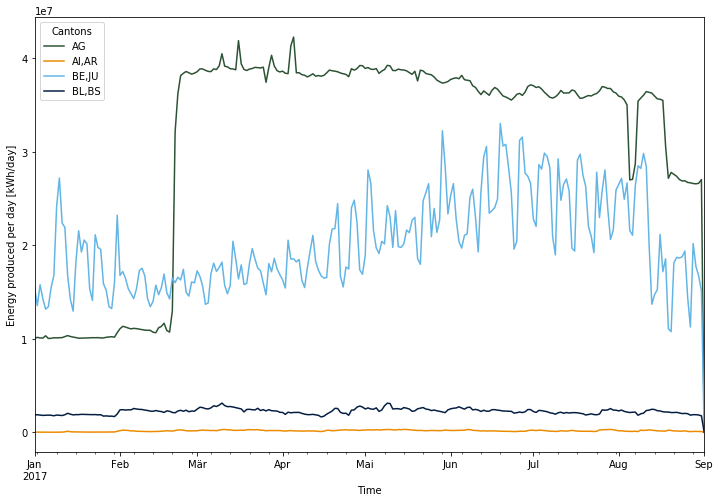

In [6]:
fig, axarr = plt.subplots(1,1, figsize =(12,8))
df_prod_wide.Production[['AG', 'AI,AR', 'BE,JU', 'BL,BS']].plot(ax=axarr, colormap=customcolors.deloitte_colormap())
axarr.set_ylabel('Energy produced per day [kWh/day]')
axarr.set_xlabel('Time');

# Working with time series data with Spark

While Pandas is convenient, the fact that it is running on a single machine is limiting its capability to handle big data volumes. We need distributed computing to spread the load across a cluster of worker nodes and avoid loading more data than a single computer can work with. My preferred solution is using Spark on HDFS, and this section will show how the equivalent of the time series resampling with Pandas above can be accomplished with Spark.

Since Spark 2.0 this has become much easier since we can now rely on Spark SQLContext dataframes and the `window()` command. Spark dataframes were introduced with Spark 1.3 and have now matured to the point that they are replacing the older Spark RDD. Dataframes have the advantage of being faster to process and have a more familiar API for users coming from SQL or Pandas. Rather than repeating all information on what a dataframe is and how it can be used, I encourage readers to read the [SQL programming guide](https://spark.apache.org/docs/latest/sql-programming-guide.html).

To try this out by yourself, you can either spin up a Spark cluster on [Azure](https://azure.microsoft.com/en-us/services/hdinsight/apache-spark/) or [AWS](https://aws.amazon.com/emr/details/spark/), run a virtual machine or Docker container, or you can make a [standalone installation](https://rsandstroem.github.io/sparkkmeans.html) on your local machine.

In [7]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import *

print (pyspark.__version__)

2.1.1+hadoop2.7


First we read in the csv file we created earlier. Using the SQLContext this can be achieved in with a single command. `inferSchema=True` will automatically identify the index column as timestamps. Alternatively the index column can be manually casted: `sdf._c0.cast('timestamp')`.

In [8]:
sqlContext = SQLContext(sc)
sdf = sqlContext.read.csv('production.csv', header=True, inferSchema=True) # requires spark 2.0 or later
print ('Number of rows: ' , sdf.count())
sdf.printSchema()
sdf.show()

Number of rows:  419832
root
 |-- _c0: timestamp (nullable = true)
 |-- Cantons: string (nullable = true)
 |-- Production: double (nullable = true)

+--------------------+-------+----------+
|                 _c0|Cantons|Production|
+--------------------+-------+----------+
|2017-01-01 00:15:...|     AG|106446.106|
|2017-01-01 00:30:...|     AG|106239.466|
|2017-01-01 00:45:...|     AG| 105475.53|
|2017-01-01 01:00:...|     AG|106305.572|
|2017-01-01 01:15:...|     AG|105376.835|
|2017-01-01 01:30:...|     AG|106327.519|
|2017-01-01 01:45:...|     AG|106397.274|
|2017-01-01 02:00:...|     AG| 106398.17|
|2017-01-01 02:15:...|     AG|105129.827|
|2017-01-01 02:30:...|     AG|105107.203|
|2017-01-01 02:45:...|     AG|106258.293|
|2017-01-01 03:00:...|     AG|106262.263|
|2017-01-01 03:15:...|     AG|106260.405|
|2017-01-01 03:30:...|     AG|105186.921|
|2017-01-01 03:45:...|     AG|105153.345|
|2017-01-01 04:00:...|     AG|106337.311|
|2017-01-01 04:15:...|     AG|105268.868|
|2017-01-01

Once the old DatetimeIndex column is correctly interpreted as a timestamp it is possible to effortlessly extract details from the timestamp. For example, the line below extracts the _time of day_ and the _name of weekday_ as separate columns. It also shows how to combine the two to provide _weekday number_ and _time of day_ as one combined string.

In [9]:
sdf.select('_c0', date_format('_c0', 'HH:mm').alias('time'), date_format('_c0', 'E').alias('weekday'), date_format('_c0', 'u HH:mm').alias('weekdaytime')).show()

+--------------------+-----+-------+-----------+
|                 _c0| time|weekday|weekdaytime|
+--------------------+-----+-------+-----------+
|2017-01-01 00:15:...|00:15|    Sun|    7 00:15|
|2017-01-01 00:30:...|00:30|    Sun|    7 00:30|
|2017-01-01 00:45:...|00:45|    Sun|    7 00:45|
|2017-01-01 01:00:...|01:00|    Sun|    7 01:00|
|2017-01-01 01:15:...|01:15|    Sun|    7 01:15|
|2017-01-01 01:30:...|01:30|    Sun|    7 01:30|
|2017-01-01 01:45:...|01:45|    Sun|    7 01:45|
|2017-01-01 02:00:...|02:00|    Sun|    7 02:00|
|2017-01-01 02:15:...|02:15|    Sun|    7 02:15|
|2017-01-01 02:30:...|02:30|    Sun|    7 02:30|
|2017-01-01 02:45:...|02:45|    Sun|    7 02:45|
|2017-01-01 03:00:...|03:00|    Sun|    7 03:00|
|2017-01-01 03:15:...|03:15|    Sun|    7 03:15|
|2017-01-01 03:30:...|03:30|    Sun|    7 03:30|
|2017-01-01 03:45:...|03:45|    Sun|    7 03:45|
|2017-01-01 04:00:...|04:00|    Sun|    7 04:00|
|2017-01-01 04:15:...|04:15|    Sun|    7 04:15|
|2017-01-01 04:30:..

## Resampling time series with Spark

In the past I had to [convert the timestamp to unix_timestamp, round it to the time window boundary, and convert back to timestamp](https://mihevc.org/2016/09/28/spark-resampling.html). It worked, but was awkward and cumbersome... With more recent version of Spark this can be done more elegantly, and with a syntax that resembles Pandas `resample()`:

In [10]:
group = sdf.groupBy('Cantons', window("_c0", "1 day")).agg(sum("Production").alias('Sum Production'))
sdf_resampled = group.select(group.window.start.alias("Start"), group.window.end.alias("End"), "Cantons", "Sum Production").orderBy('Start', ascending=True)
sdf_resampled.printSchema()
sdf_resampled.show()

root
 |-- Start: timestamp (nullable = true)
 |-- End: timestamp (nullable = true)
 |-- Cantons: string (nullable = true)
 |-- Sum Production: double (nullable = true)

+--------------------+--------------------+--------+------------------+
|               Start|                 End| Cantons|    Sum Production|
+--------------------+--------------------+--------+------------------+
|2016-12-31 01:00:...|2017-01-01 01:00:...|   SZ,ZG|          4355.656|
|2016-12-31 01:00:...|2017-01-01 01:00:...|      NE|           1433.12|
|2016-12-31 01:00:...|2017-01-01 01:00:...|      FR|14917.206999999999|
|2016-12-31 01:00:...|2017-01-01 01:00:...|   GE,VD|63320.399000000005|
|2016-12-31 01:00:...|2017-01-01 01:00:...|      SG|        22628.4624|
|2016-12-31 01:00:...|2017-01-01 01:00:...|      TG|          5983.481|
|2016-12-31 01:00:...|2017-01-01 01:00:...|   SH,ZH|         63015.216|
|2016-12-31 01:00:...|2017-01-01 01:00:...|      GL|57300.575000000004|
|2016-12-31 01:00:...|2017-01-01 01:00:

The time columns differ by one hour from the previous ones due to that local time (CET) is UTC + 1 hour.

Just like with Pandas, we can pivot the dataframe to have the daily energy production measurements by canton as individual columns.

In [11]:
sdf_wide = sdf_resampled.groupBy("Start").pivot("Cantons").agg(avg("Sum Production"))
sdf_wide.printSchema()
sdf_wide.take(2)

root
 |-- Start: timestamp (nullable = true)
 |-- AG: double (nullable = true)
 |-- AI,AR: double (nullable = true)
 |-- BE,JU: double (nullable = true)
 |-- BL,BS: double (nullable = true)
 |-- FR: double (nullable = true)
 |-- GE,VD: double (nullable = true)
 |-- GL: double (nullable = true)
 |-- GR: double (nullable = true)
 |-- LU: double (nullable = true)
 |-- NE: double (nullable = true)
 |-- OW,NW,UR: double (nullable = true)
 |-- SG: double (nullable = true)
 |-- SH,ZH: double (nullable = true)
 |-- SO: double (nullable = true)
 |-- SZ,ZG: double (nullable = true)
 |-- TG: double (nullable = true)
 |-- TI: double (nullable = true)
 |-- VS: double (nullable = true)



[Row(Start=datetime.datetime(2016, 12, 31, 1, 0), AG=318161.10199999996, AI,AR=639.0346000000001, BE,JU=522068.77, BL,BS=59174.242, FR=14917.206999999999, GE,VD=63320.399000000005, GL=57300.575000000004, GR=248141.154, LU=18330.754999999997, NE=1433.12, OW,NW,UR=52231.888999999996, SG=22628.4624, SH,ZH=63015.216, SO=788508.46, SZ,ZG=4355.656, TG=5983.481, TI=213930.758, VS=668614.759),
 Row(Start=datetime.datetime(2017, 1, 1, 1, 0), AG=10181572.696999999, AI,AR=37873.508400000006, BE,JU=15577828.093999993, BL,BS=1893298.3760000006, FR=655977.4039999997, GE,VD=1965485.1110000005, GL=590569.458, GR=6564026.570000001, LU=695454.2899999998, NE=36113.68999999998, OW,NW,UR=1012020.1090000004, SG=785312.6816, SH,ZH=2115150.886, SO=25277348.167000007, SZ,ZG=268551.99900000007, TG=238868.153, TI=5127906.498000002, VS=20461922.031)]

# Visualize results

To visualize the data we first convert the resampled Spark dataframe to a Pandas dataframe, and rank the cantons by their total energy production since the beginning of the year.

Total production by canton [GWh]:
AG          7595.381332
VS          6761.848072
SO          5582.169178
BE,JU       4935.914846
GR          4565.721103
TI          2262.869675
GE,VD       1776.388252
GL           846.119517
OW,NW,UR     736.932890
SH,ZH        617.724426
SG           591.855536
FR           550.580602
BL,BS        548.836063
LU           424.767325
SZ,ZG        268.126934
TG           110.651244
AI,AR         43.602210
NE            21.024362
dtype: float64


,AG,"AI,AR","BE,JU","BL,BS",FR,"GE,VD",GL,GR,LU,NE,"OW,NW,UR",SG,"SH,ZH",SO,"SZ,ZG",TG,TI,VS
Start,,,,,,,,,,,,,,,,,,
2017-08-27 02:00:00,26.684688,0.089646,11.224083,1.850375,0.671459,4.326829,3.685370,8.880586,2.272688,0.026307,2.450664,1.615026,2.541175,25.009497,0.447012,0.347095,5.432692,31.637149
2017-08-28 02:00:00,26.607201,0.109748,20.350693,1.899463,2.645319,7.022427,4.695076,18.564002,2.163915,0.034941,3.066084,3.117943,2.601915,25.037800,0.599931,0.369885,11.029386,44.002625
2017-08-29 02:00:00,26.599007,0.114856,17.710304,1.899542,2.773213,7.100725,4.989526,19.128244,2.164662,0.041536,3.081705,3.965417,2.672351,25.109403,0.582909,0.413893,11.504299,43.317634
2017-08-30 02:00:00,26.630764,0.100228,16.742514,1.865723,2.560811,7.158615,4.326003,14.891317,2.228436,0.030702,3.129639,3.148480,2.542011,25.198063,0.527408,0.370532,10.970139,42.633497
2017-08-31 02:00:00,25.112052,0.101069,14.363601,1.663916,2.015289,6.220193,3.220247,15.582130,2.161802,0.014276,3.357727,1.936459,2.145381,23.773442,0.538766,0.194042,10.104623,41.556045


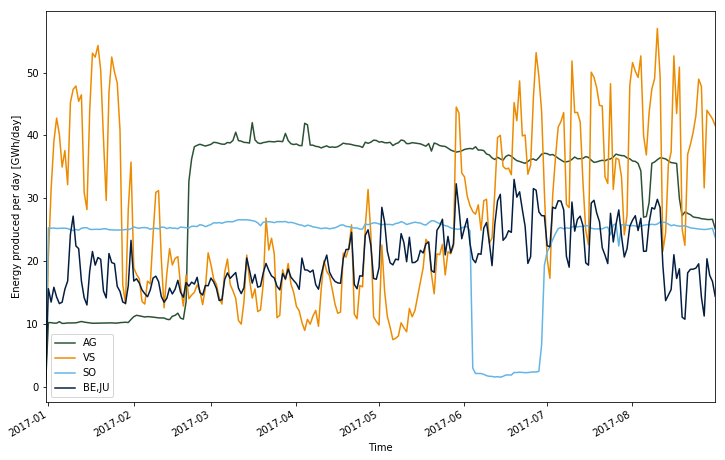

In [12]:
pdf_wide = sdf_wide.toPandas().set_index("Start").divide(1e6) # convert kWh to GWh
print ("Total production by canton [GWh]:")
print (pdf_wide.sum().sort_values(ascending=False))
display (pdf_wide.tail())
fig, axarr = plt.subplots(1,1, figsize =(12,8))
pdf_wide[['AG', 'VS', 'SO', 'BE,JU']].plot(ax=axarr, colormap=customcolors.deloitte_colormap())
axarr.set_ylabel('Energy produced per day [GWh/day]')
axarr.set_xlabel('Time');

The energy production of the cantons have very different characteristics. 
- Aargau (AR) is obviously dominated by man-controlled energy sources, and this is no surprise since most of Switzerland's nuclear power is situated in Aargau.
- The neighbor Solothurn (SO) also have a nuclear power plant and not much else.
- Valais (VS), on the other hand, is high alpine region and its energy production is dominated by Hydroelectric energy. This is the source of the strong dependence of seasonality.
- Bern (BE) and Jura (JU), have one nuclear power plant, but also high mountains which are home to hydroelectric, wind and photo-voltaic energy sources.

This visualization gives a hint at the energy strategy of the country; energy production is based on hydroelectric power, but nuclear compensates for periods when renewable energy is not meeting the needs of the country.

# Summary

This post has demonstrated how to pivot and resample time series in Pandas and Spark. The data used for this exercise is real measurements of energy production in Switzerland. The resampled data shows evidence of where nuclear power plant and renewable energy sources are located.